Dependencies:<br>
- Pls make sure u create a 'cGAN' folder in the same directory as this file to save weights
- pip/conda install any missing modules (especially tensorflow_addons)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K
from tensorflow import keras
from keras.layers import Reshape, Conv2DTranspose, PReLU
from keras.utils import to_categorical, plot_model
from keras.layers import Concatenate
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.image import resize
from scipy.linalg import sqrtm
import math
# from tqdm.notebook import tqdm
import tensorflow as tf
from IPython.display import clear_output, HTML
import glob
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential, Model
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal
from tensorflow_addons.layers import SpectralNormalization
from keras.layers import LeakyReLU, GlobalMaxPooling2D, GlobalAveragePooling2D

c:\Users\hazem\anaconda3\envs\gpu_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\hazem\anaconda3\envs\gpu_env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
I

In [2]:
tf.__version__

'2.15.0'

In [3]:
from keras.datasets.cifar10 import load_data

(X_train, y_train), (X_test, y_test) = load_data()
X_train = np.concatenate((X_train, X_test), axis=0)
y_train = np.concatenate((y_train, y_test), axis=0)



In [23]:
type(X_train)

numpy.ndarray

In [4]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomCrop(32,32),
  # tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

X_train_aug = data_augmentation(X_train)
X_train = np.concatenate((X_train, X_train_aug), axis=0)

if X_train.shape[0] > 60000:
    y_train = np.concatenate((y_train, y_train), axis=0)

In [5]:
class_labels = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}

NUM_CLASS = 10

y_train = to_categorical(y_train)
pre_processing_v1 = Normalization()
pre_processing_v1.adapt(X_train)
X_train = X_train.astype('float32')
X_train /= (255/2)
X_train -= 1

In [6]:
noise = 128

# function to create generator model
def create_improve_cGAN_generator(noise):

    # gaussian weights initialization
    weights_init = RandomNormal(mean=0, stddev=0.02)

    # latent noise vector z
    z = Input(shape=(noise,), name="Latent_Noise_Vector_z")

    # conditions y
    conditions = Input(shape=(10,), name='Conditions_y')

    # Generator network
    merged_layer = Concatenate()([z, conditions])

    # FC: 2x2x512
    generator = Dense(2*2*512, activation='relu')(merged_layer)
    generator = BatchNormalization(momentum=0.8)(generator)
    generator = PReLU()(generator)
    generator = Reshape((2, 2, 512))(generator)

    base_generator = Sequential([
        # Conv 1: 4x4x256
        SpectralNormalization(Conv2DTranspose(256, kernel_size=4, strides=2,
                                              padding='same', kernel_initializer=weights_init)),
        BatchNormalization(momentum=0.8),
        PReLU(),
        # Conv 2: 8x8x128
        SpectralNormalization(Conv2DTranspose(128, kernel_size=4, strides=2,
                                              padding='same', kernel_initializer=weights_init)),
        BatchNormalization(momentum=0.8),
        PReLU(),
        # Conv 3: 16x16x64
        SpectralNormalization(Conv2DTranspose(64, kernel_size=4, strides=2,
                                              padding='same', kernel_initializer=weights_init)),
        BatchNormalization(momentum=0.8),
        PReLU(),
    ], name='Base_Generator')
    generator = base_generator(generator)

    # Conv 4: 32x32x3
    generator = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same',
                                activation='tanh', name='Output_Layer')(generator)

    generator = Model(inputs=[z, conditions],
                      outputs=generator,  name='generator_cGAN')
    return generator

In [7]:
# function to create discriminator model
def create_improve_cGAN_discriminator(image_size):
    # input image
    img_input = Input(shape=(image_size), name='Image_Input')
    weights_init = RandomNormal(mean=0, stddev=0.02)

    # conditions y
    conditions = Input(shape=(10,), name='Conditions_y')

    base_discriminator = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding='same',
               kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        Conv2D(128, kernel_size=4, strides=2, padding='same',
               kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        Conv2D(256, kernel_size=4, strides=2, padding='same',
               kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        Conv2D(512, kernel_size=4, strides=2, padding='same',
               kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
    ], name='Base_Discriminator')
    discriminator = base_discriminator(img_input)

    discriminator = GlobalAveragePooling2D()(discriminator)

    # Concatenate - combine with conditions y
    merged_layer = Concatenate()([discriminator, conditions])
    discriminator = Dense(512, activation='relu')(merged_layer)

    # Output
    discriminator = Dense(1,
                          name='Output_Layer')(discriminator)

    discriminator = Model(inputs=[img_input, conditions],
                          outputs=discriminator, name='discriminator_cGAN')
    return discriminator

In [8]:
class NewcGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=20, noise=128, patience=10, vmin=0, vmax=1):
        self.num_img = num_img
        self.noise = noise
        self.patience = patience
        self.vmin = vmin
        self.vmax = vmax
        self.latent_noise_vector = tf.random.normal(
            shape=(self.num_img, self.noise))
        self.conditions = to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                          0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    def generate_plot(self):
        # Generate Images
        generated_images = self.model.generator.predict(
            [self.latent_noise_vector, self.conditions])
        # Normalise Image from [vmin, vmax] to [0, 1]
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)
        row_size = int(np.ceil(self.num_img/5))
        fig = plt.figure(figsize=(10, 2*row_size), tight_layout=True)
        for i in range(self.num_img):
            ax = fig.add_subplot(row_size, 5, i+1)
            ax.imshow(generated_images[i])
            ax.set_title(class_labels[i % 10])
            ax.axis('off')
        plt.show()

    def save_weights(self, epoch=None):
        try:
            if epoch != None:
                name = 'cGAN/generator-epoch-{}.h5'.format(epoch)
                print('Generator Checkpoint - {}'.format(name))
                self.model.generator.save_weights(
                    filepath=name,
                    save_format='h5'
                )
        except Exception as e:
            print(e)

    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.patience == 0:
            self.generate_plot()
            self.save_weights(epoch)

    def on_train_end(self, epoch, logs=None):
        self.generate_plot()
        self.save_weights('Full Train')


In [9]:
callbacks = [
    NewcGANMonitor(num_img=20, noise=128, patience=5, vmin=-1, vmax=1),
]


In [10]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, noise):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.noise = noise
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(
            name="discriminator_loss")
        # self.d_xy_tracker = tf.keras.metrics.Mean(name='Mean D(x|y)')
        # self.d_g_zy_tracker = tf.keras.metrics.Mean(name='Mean D(G(z|y))')
        self.kl = tf.keras.metrics.KLDivergence()

    def compile(self, d_optimizer, g_optimizer, gloss_fn, dloss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.gloss_fn = gloss_fn
        self.dloss_fn = dloss_fn

    def train_step(self, data):
        ### TRAINING DISCRIMINATOR ###
        # Unpack the data.
        real_images, condition = data

        # Sample for latent noise vector z
        batch_size = tf.shape(real_images)[0]
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.noise))

        # Maps the noise latent vector and labels to generate fake images.
        generated_images = self.generator([latent_noise_vector, condition])

        # Combine with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        combined_condition = tf.concat([condition, condition], axis=0)

        # Discrimination
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            first_predictions = self.discriminator(
                [combined_images, combined_condition])
            d_loss = self.dloss_fn(labels, first_predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # # Computing D(x|y)
        # d_xy = tf.math.reduce_mean(first_predictions)

        ### TRAINING GENRATOR ###
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.noise))

        # Assemble labels that say "all real images".
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator([latent_noise_vector, condition])
            second_predictions = self.discriminator([fake_images, condition])
            g_loss = self.gloss_fn(misleading_labels, second_predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        # # Computing D(G(z|y))
        # d_g_zy = tf.math.reduce_mean(second_predictions)

        # Monitor loss and metrics.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.kl.update_state(y_true=real_images, y_pred=generated_images)

        return {
            "d_loss": self.disc_loss_tracker.result(),
            "g_loss": self.gen_loss_tracker.result(),
            "KL Divergence": self.kl.result(),
        }

In [11]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    # we compare the prediction on real images to 0.8 instead of 1
    real_loss = loss_function(tf.ones_like(real_output)*0.8, real_output)
    # real_loss will quantify our loss to distinguish the real images
    
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    # fake_loss will quantify our loss to distinguish the fake images (generated)
    
    # Two-sided label smoothing : 
    # Uncomment the next line and comment the last one if you want to try it
#     fake_loss = loss_function(tf.ones_like(fake_output)*0.1, fake_output)
    
    # Real image = 1, Fake image = 0 (array of ones and zeros)
    total_loss = real_loss + fake_loss
    return total_loss

# def generator_loss(fake_output):
#     # We want the false images to be seen as real images (1)
#     return loss_function(tf.ones_like(fake_output), fake_output)

In [14]:
improve_cond_gan = ConditionalGAN(
    discriminator=create_improve_cGAN_discriminator(image_size=(32, 32, 3)),
    generator=create_improve_cGAN_generator(noise=128),
    noise=128
)

improve_cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    gloss_fn=loss_function,
    dloss_fn=loss_function
)

c:\Users\hazem\anaconda3\envs\gpu_env\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 0s 132ms/step


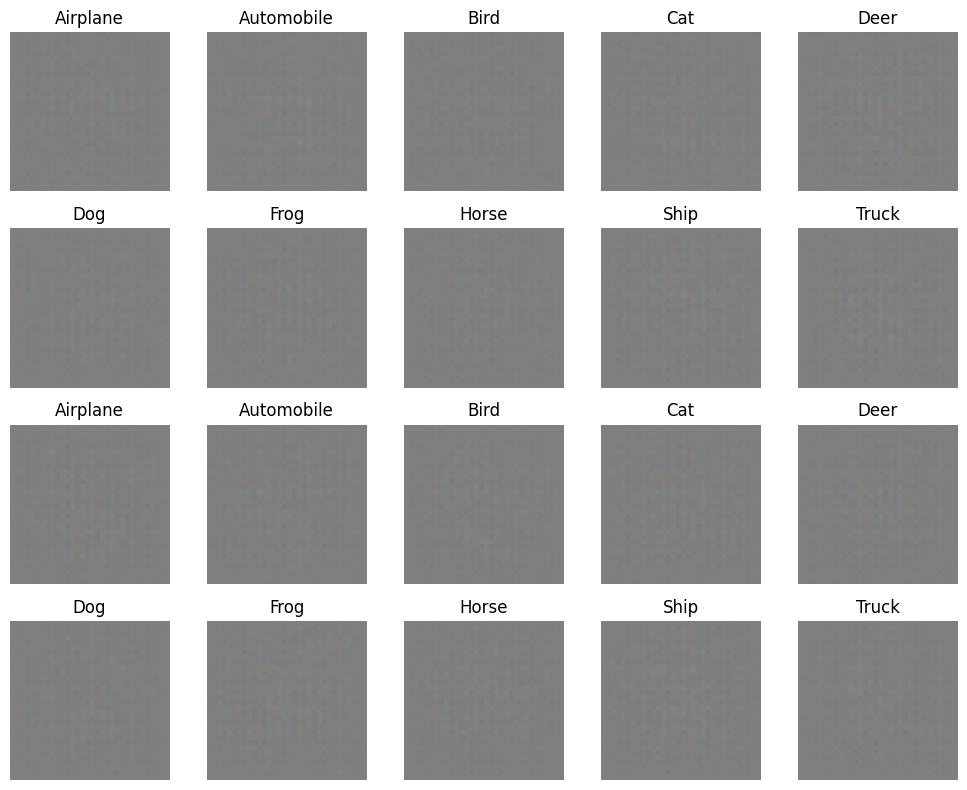

Generator Checkpoint - cGAN/generator-epoch-0.h5
Epoch 1/100
1875/1875 [==============================] - 280s 148ms/step - d_loss: 0.2821 - g_loss: 3.3315 - KL Divergence: 6.1021
Epoch 2/100
1875/1875 [==============================] - 274s 146ms/step - d_loss: 0.2341 - g_loss: 3.3574 - KL Divergence: 6.3399
Epoch 3/100
1875/1875 [==============================] - 271s 145ms/step - d_loss: 0.2886 - g_loss: 2.8407 - KL Divergence: 5.3156
Epoch 4/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.3149 - g_loss: 2.6410 - KL Divergence: 4.9723
Epoch 5/100
1/1 [==============================] - 0s 22ms/step


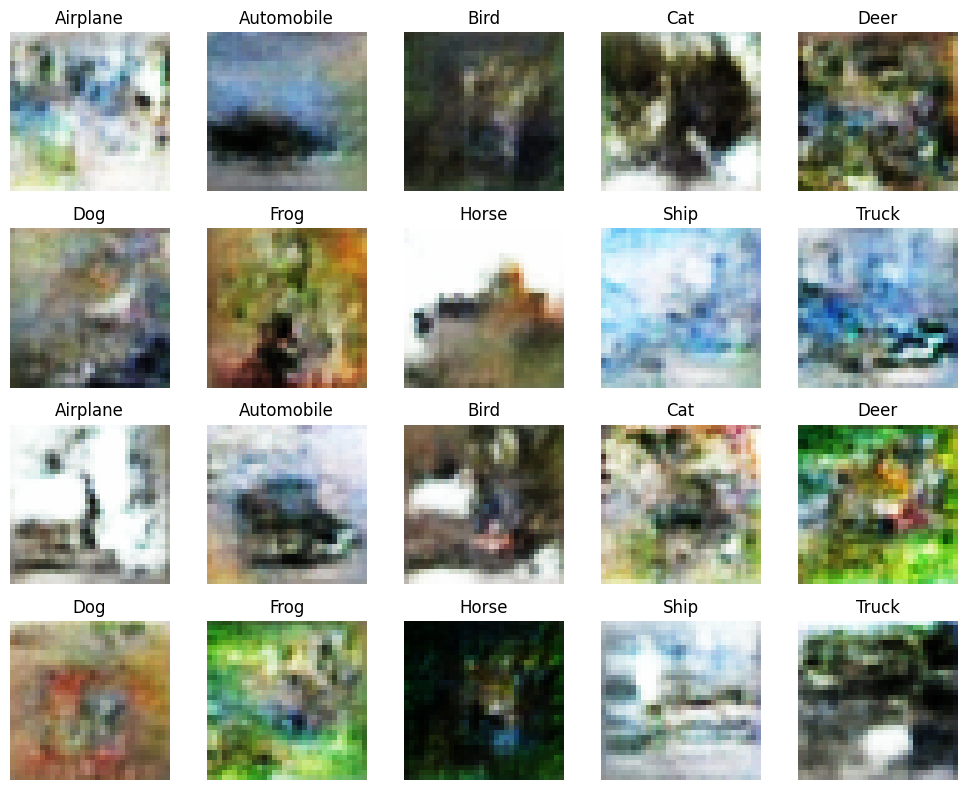

Generator Checkpoint - cGAN/generator-epoch-5.h5
Epoch 6/100
1875/1875 [==============================] - 268s 143ms/step - d_loss: 0.3103 - g_loss: 2.5932 - KL Divergence: 4.4738
Epoch 7/100
1875/1875 [==============================] - 271s 145ms/step - d_loss: 0.3178 - g_loss: 2.4598 - KL Divergence: 4.6226
Epoch 8/100
1875/1875 [==============================] - 273s 145ms/step - d_loss: 0.3310 - g_loss: 2.3686 - KL Divergence: 4.6441
Epoch 9/100
1875/1875 [==============================] - 274s 146ms/step - d_loss: 0.3120 - g_loss: 2.4270 - KL Divergence: 4.5976
Epoch 10/100
1/1 [==============================] - 0s 22ms/step


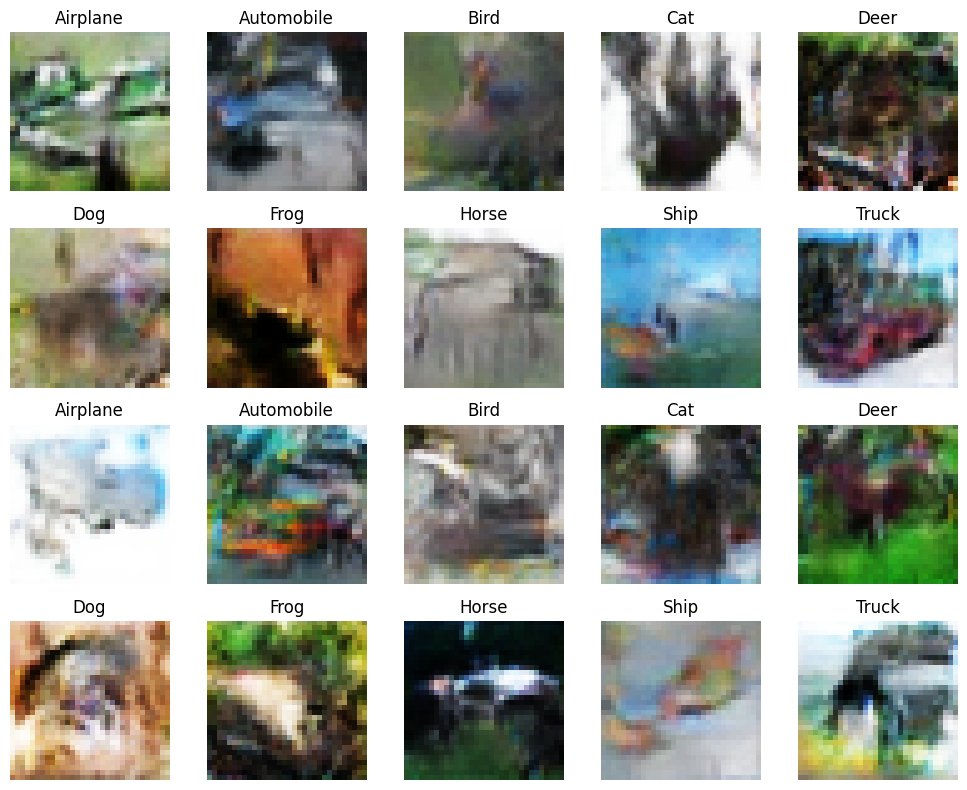

Generator Checkpoint - cGAN/generator-epoch-10.h5
Epoch 11/100
1875/1875 [==============================] - 273s 146ms/step - d_loss: 0.3002 - g_loss: 2.5499 - KL Divergence: 4.6646
Epoch 12/100
1875/1875 [==============================] - 273s 146ms/step - d_loss: 0.2970 - g_loss: 2.5856 - KL Divergence: 4.6502
Epoch 13/100
1875/1875 [==============================] - 273s 145ms/step - d_loss: 0.2904 - g_loss: 2.6576 - KL Divergence: 4.7017
Epoch 14/100
1875/1875 [==============================] - 274s 146ms/step - d_loss: 0.2817 - g_loss: 2.7529 - KL Divergence: 4.7220
Epoch 15/100
1/1 [==============================] - 0s 23ms/step


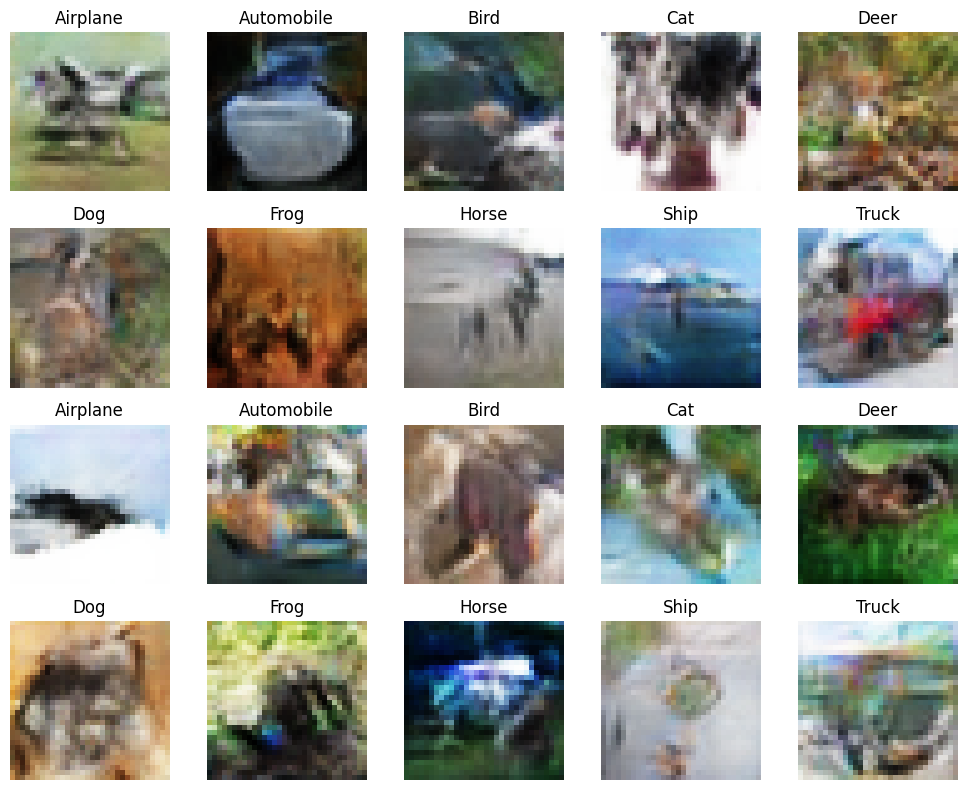

Generator Checkpoint - cGAN/generator-epoch-15.h5
Epoch 16/100
1875/1875 [==============================] - 269s 144ms/step - d_loss: 0.2629 - g_loss: 2.9333 - KL Divergence: 4.7471
Epoch 17/100
1875/1875 [==============================] - 268s 143ms/step - d_loss: 0.2524 - g_loss: 3.0648 - KL Divergence: 4.7576
Epoch 18/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.2477 - g_loss: 3.1141 - KL Divergence: 4.7982
Epoch 19/100
1875/1875 [==============================] - 268s 143ms/step - d_loss: 0.2352 - g_loss: 3.2647 - KL Divergence: 4.7211
Epoch 20/100
1/1 [==============================] - 0s 23ms/step


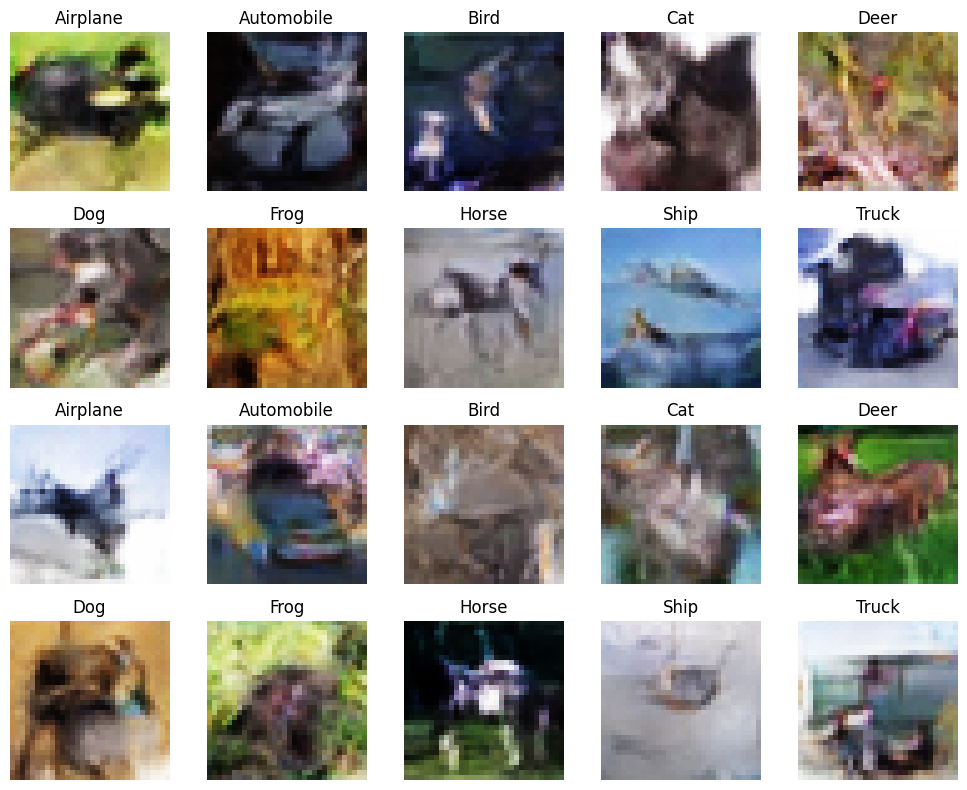

Generator Checkpoint - cGAN/generator-epoch-20.h5
Epoch 21/100
1875/1875 [==============================] - 272s 145ms/step - d_loss: 0.2168 - g_loss: 3.5471 - KL Divergence: 4.7275
Epoch 22/100
1875/1875 [==============================] - 271s 144ms/step - d_loss: 0.2114 - g_loss: 3.6157 - KL Divergence: 4.7601
Epoch 23/100
1875/1875 [==============================] - 272s 145ms/step - d_loss: 0.2032 - g_loss: 3.7859 - KL Divergence: 4.6894
Epoch 24/100
1875/1875 [==============================] - 276s 147ms/step - d_loss: 0.2010 - g_loss: 3.8487 - KL Divergence: 4.7371
Epoch 25/100
1/1 [==============================] - 0s 22ms/step


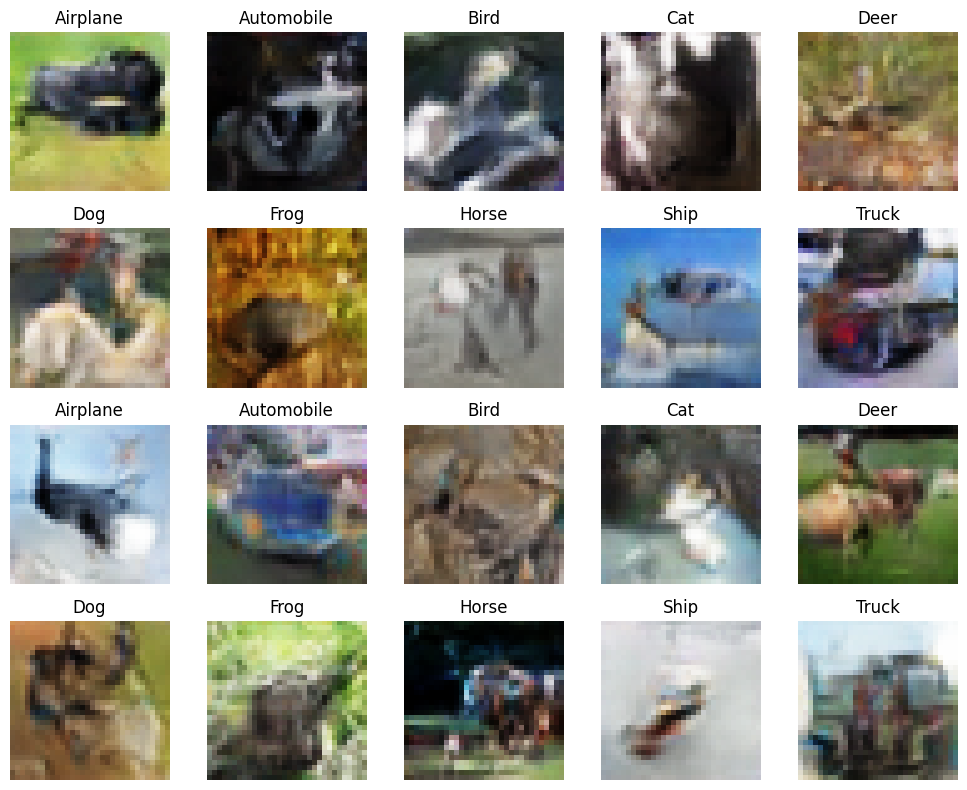

Generator Checkpoint - cGAN/generator-epoch-25.h5
Epoch 26/100
1875/1875 [==============================] - 273s 146ms/step - d_loss: 0.1909 - g_loss: 4.0673 - KL Divergence: 4.7770
Epoch 27/100
1875/1875 [==============================] - 277s 148ms/step - d_loss: 0.1853 - g_loss: 4.1509 - KL Divergence: 4.7263
Epoch 28/100
1875/1875 [==============================] - 270s 144ms/step - d_loss: 0.1809 - g_loss: 4.2744 - KL Divergence: 4.7595
Epoch 29/100
1875/1875 [==============================] - 278s 148ms/step - d_loss: 0.1815 - g_loss: 4.2760 - KL Divergence: 4.6969
Epoch 30/100
1/1 [==============================] - 0s 21ms/step


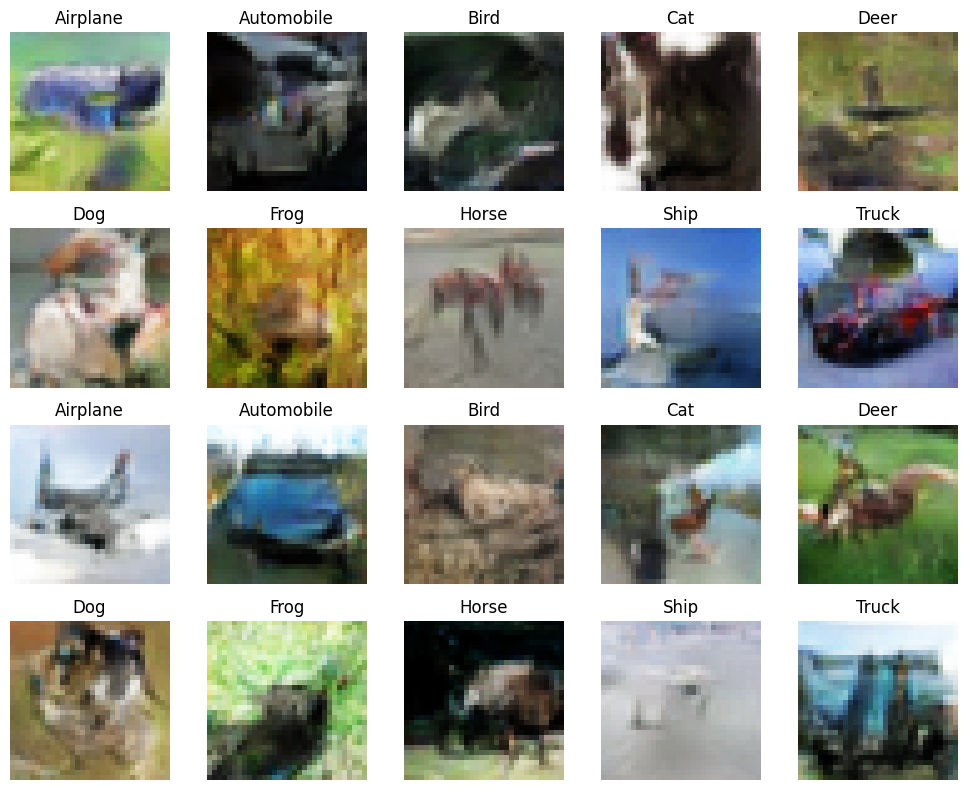

Generator Checkpoint - cGAN/generator-epoch-30.h5
Epoch 31/100
1875/1875 [==============================] - 266s 142ms/step - d_loss: 0.1682 - g_loss: 4.5403 - KL Divergence: 4.6540
Epoch 32/100
1875/1875 [==============================] - 266s 142ms/step - d_loss: 0.1635 - g_loss: 4.5632 - KL Divergence: 4.6480
Epoch 33/100
1875/1875 [==============================] - 269s 143ms/step - d_loss: 0.1632 - g_loss: 4.6876 - KL Divergence: 4.6833
Epoch 34/100
1875/1875 [==============================] - 266s 142ms/step - d_loss: 0.1641 - g_loss: 4.7648 - KL Divergence: 4.7034
Epoch 35/100
1/1 [==============================] - 0s 21ms/step


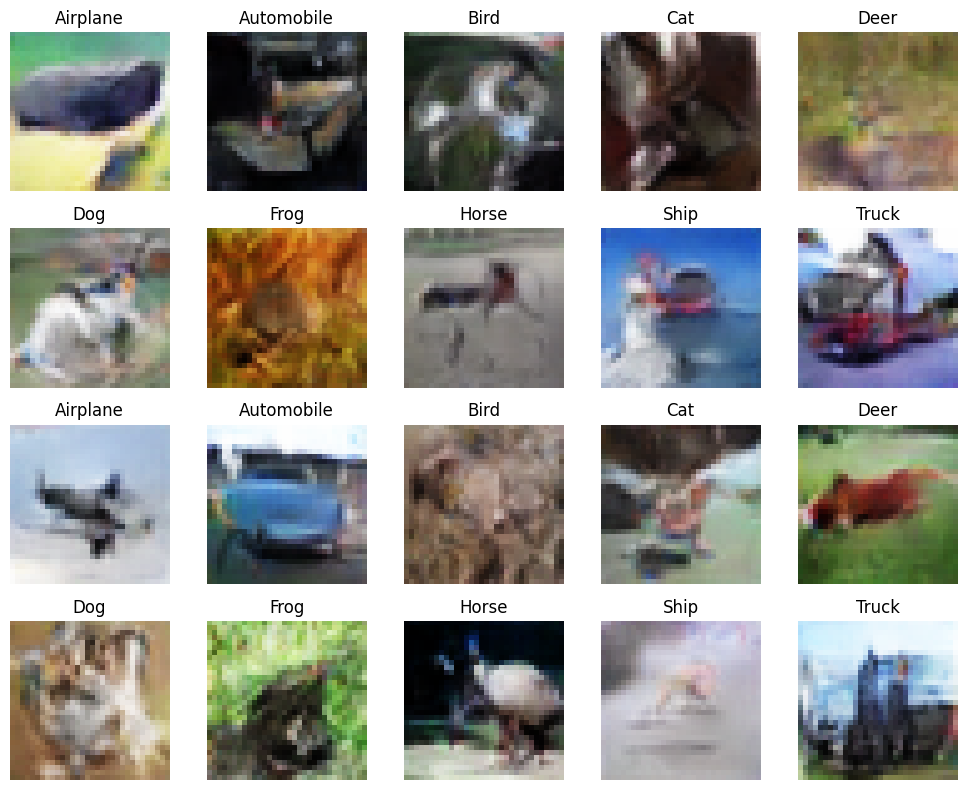

Generator Checkpoint - cGAN/generator-epoch-35.h5
Epoch 36/100
1875/1875 [==============================] - 267s 143ms/step - d_loss: 0.1540 - g_loss: 4.9101 - KL Divergence: 4.6719
Epoch 37/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.1514 - g_loss: 5.0016 - KL Divergence: 4.6782
Epoch 38/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.1510 - g_loss: 5.0431 - KL Divergence: 4.7418
Epoch 39/100
1875/1875 [==============================] - 268s 143ms/step - d_loss: 0.1509 - g_loss: 5.0656 - KL Divergence: 4.6220
Epoch 40/100
1/1 [==============================] - 0s 20ms/step


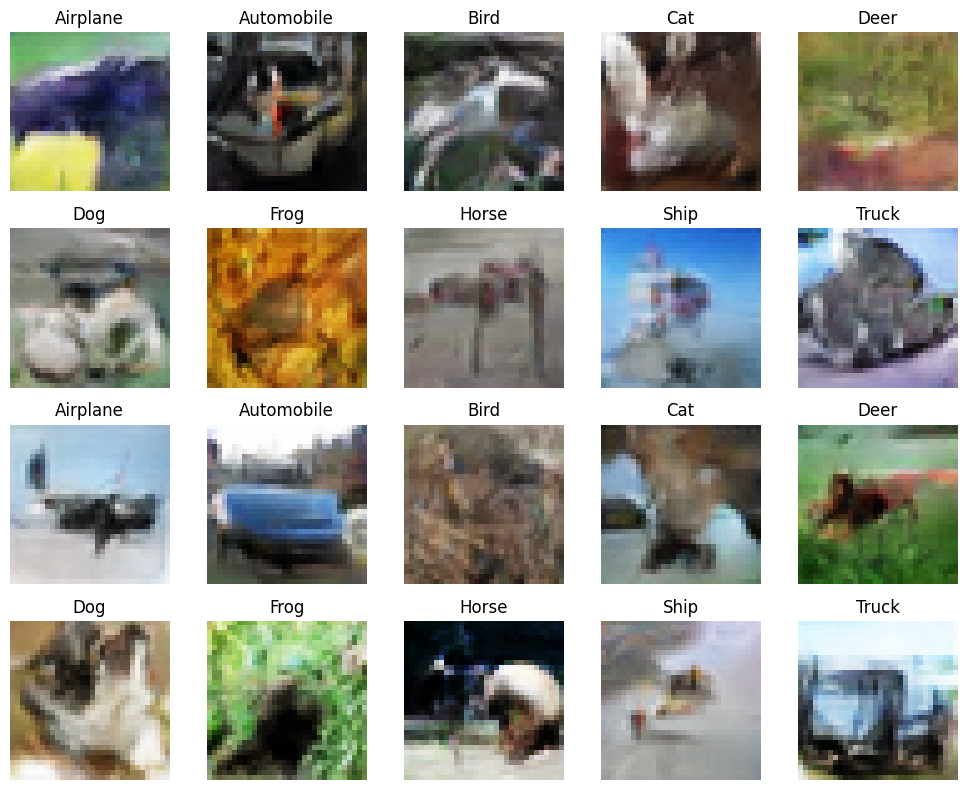

Generator Checkpoint - cGAN/generator-epoch-40.h5
Epoch 41/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.1484 - g_loss: 5.2278 - KL Divergence: 4.6387
Epoch 42/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.1482 - g_loss: 5.2416 - KL Divergence: 4.7155
Epoch 43/100
1875/1875 [==============================] - 270s 144ms/step - d_loss: 0.1440 - g_loss: 5.3097 - KL Divergence: 4.5251
Epoch 44/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.1453 - g_loss: 5.3269 - KL Divergence: 4.6976
Epoch 45/100
1/1 [==============================] - 0s 22ms/step


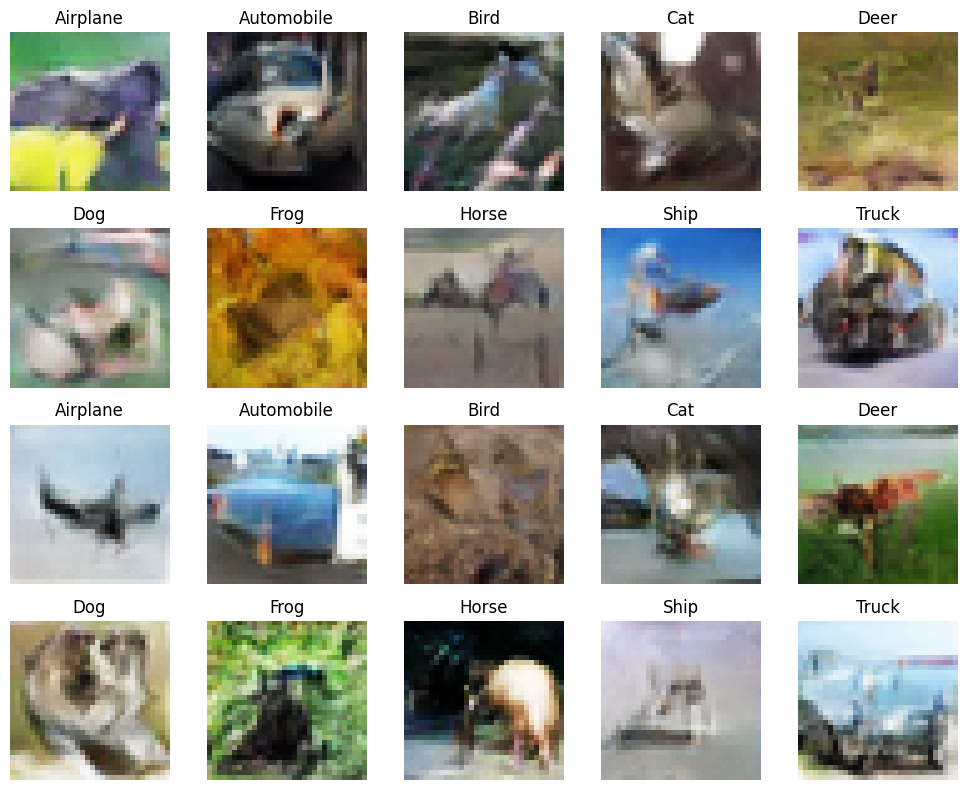

Generator Checkpoint - cGAN/generator-epoch-45.h5
Epoch 46/100
1875/1875 [==============================] - 271s 144ms/step - d_loss: 0.1372 - g_loss: 5.4514 - KL Divergence: 4.6131
Epoch 47/100
1875/1875 [==============================] - 266s 142ms/step - d_loss: 0.1423 - g_loss: 5.4507 - KL Divergence: 4.6659
Epoch 48/100
1875/1875 [==============================] - 270s 144ms/step - d_loss: 0.1392 - g_loss: 5.5232 - KL Divergence: 4.7877
Epoch 49/100
1875/1875 [==============================] - 279s 149ms/step - d_loss: 0.1395 - g_loss: 5.5722 - KL Divergence: 4.6756
Epoch 50/100
1/1 [==============================] - 0s 29ms/step


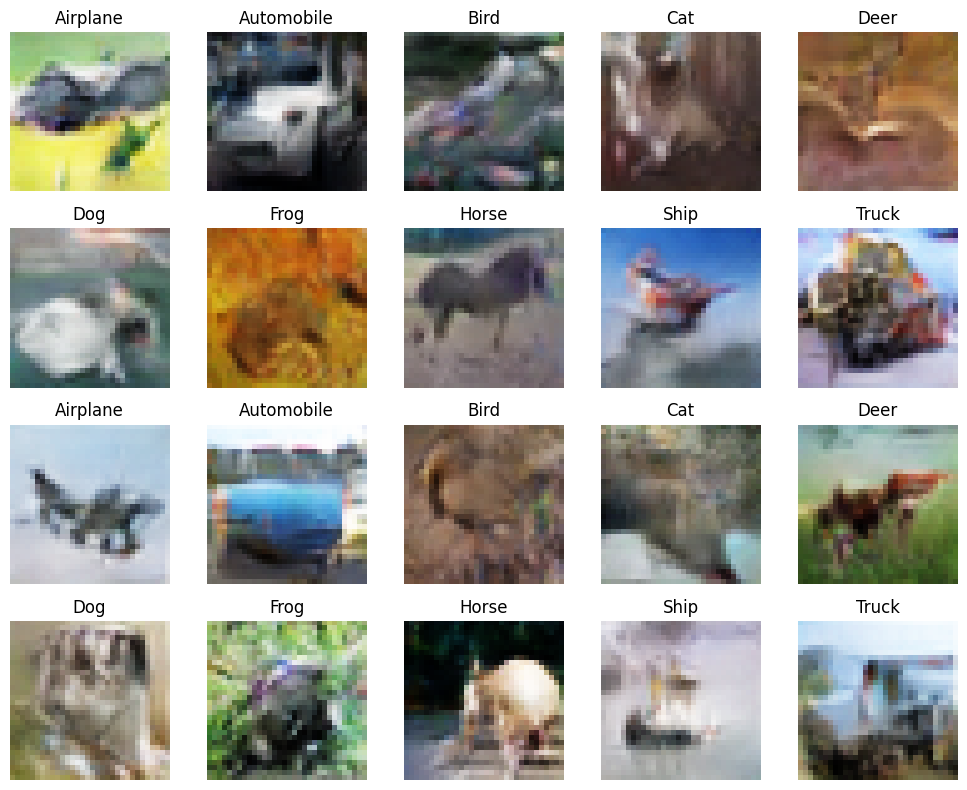

Generator Checkpoint - cGAN/generator-epoch-50.h5
Epoch 51/100
1875/1875 [==============================] - 271s 144ms/step - d_loss: 0.1396 - g_loss: 5.5881 - KL Divergence: 4.6650
Epoch 52/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.1327 - g_loss: 5.6722 - KL Divergence: 4.6453
Epoch 53/100
1875/1875 [==============================] - 265s 141ms/step - d_loss: 0.1358 - g_loss: 5.6872 - KL Divergence: 4.7000
Epoch 54/100
1875/1875 [==============================] - 264s 141ms/step - d_loss: 0.1322 - g_loss: 5.7833 - KL Divergence: 4.6595
Epoch 55/100
1/1 [==============================] - 0s 21ms/step


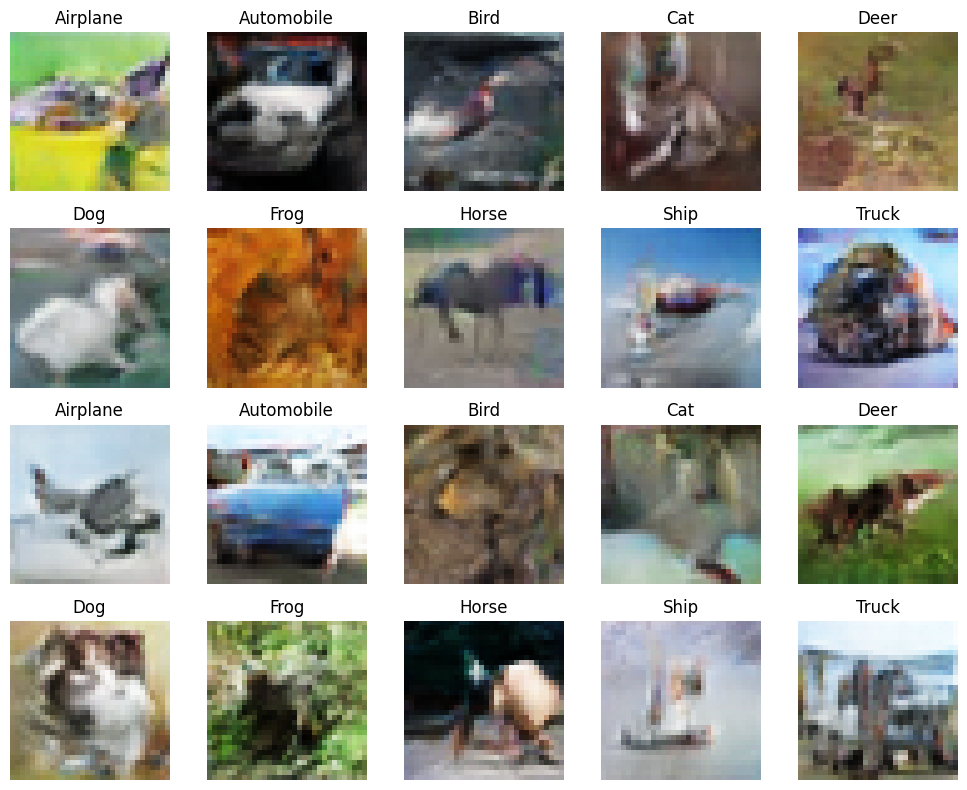

Generator Checkpoint - cGAN/generator-epoch-55.h5
Epoch 56/100
1875/1875 [==============================] - 264s 141ms/step - d_loss: 0.1293 - g_loss: 5.8479 - KL Divergence: 4.7187
Epoch 57/100
1875/1875 [==============================] - 266s 142ms/step - d_loss: 0.1285 - g_loss: 5.8747 - KL Divergence: 4.6459
Epoch 58/100
1875/1875 [==============================] - 263s 140ms/step - d_loss: 0.1260 - g_loss: 5.9498 - KL Divergence: 4.5555
Epoch 59/100
1875/1875 [==============================] - 263s 140ms/step - d_loss: 0.1230 - g_loss: 6.0009 - KL Divergence: 4.4701
Epoch 60/100
1/1 [==============================] - 0s 22ms/step


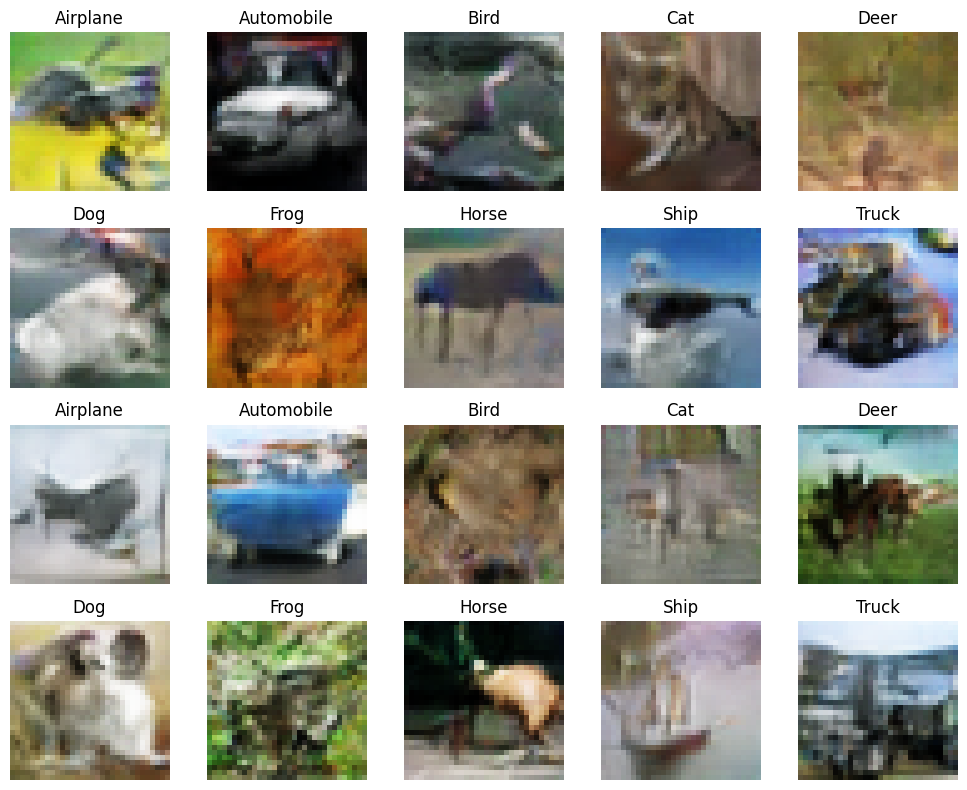

Generator Checkpoint - cGAN/generator-epoch-60.h5
Epoch 61/100
1875/1875 [==============================] - 263s 140ms/step - d_loss: 0.1225 - g_loss: 6.0558 - KL Divergence: 4.6665
Epoch 62/100
1875/1875 [==============================] - 263s 140ms/step - d_loss: 0.1207 - g_loss: 6.1093 - KL Divergence: 4.8056
Epoch 63/100
1875/1875 [==============================] - 297s 158ms/step - d_loss: 0.1189 - g_loss: 6.1579 - KL Divergence: 4.6029
Epoch 64/100
1875/1875 [==============================] - 304s 162ms/step - d_loss: 0.1214 - g_loss: 6.1085 - KL Divergence: 4.5985
Epoch 65/100
1/1 [==============================] - 0s 23ms/step


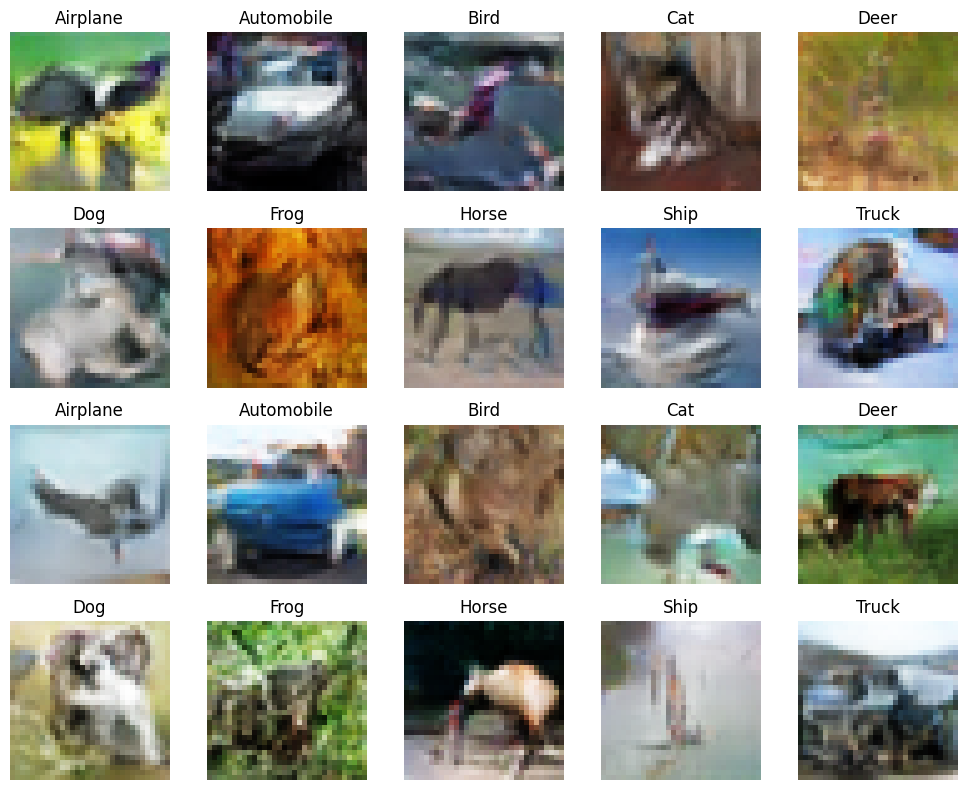

Generator Checkpoint - cGAN/generator-epoch-65.h5
Epoch 66/100
1875/1875 [==============================] - 313s 167ms/step - d_loss: 0.1203 - g_loss: 6.2537 - KL Divergence: 4.5490
Epoch 67/100
1875/1875 [==============================] - 297s 158ms/step - d_loss: 0.1178 - g_loss: 6.2439 - KL Divergence: 4.5633
Epoch 68/100
1875/1875 [==============================] - 278s 148ms/step - d_loss: 0.1156 - g_loss: 6.3793 - KL Divergence: 4.6108
Epoch 69/100
1875/1875 [==============================] - 279s 149ms/step - d_loss: 0.1127 - g_loss: 6.4118 - KL Divergence: 4.4420
Epoch 70/100
1/1 [==============================] - 0s 24ms/step


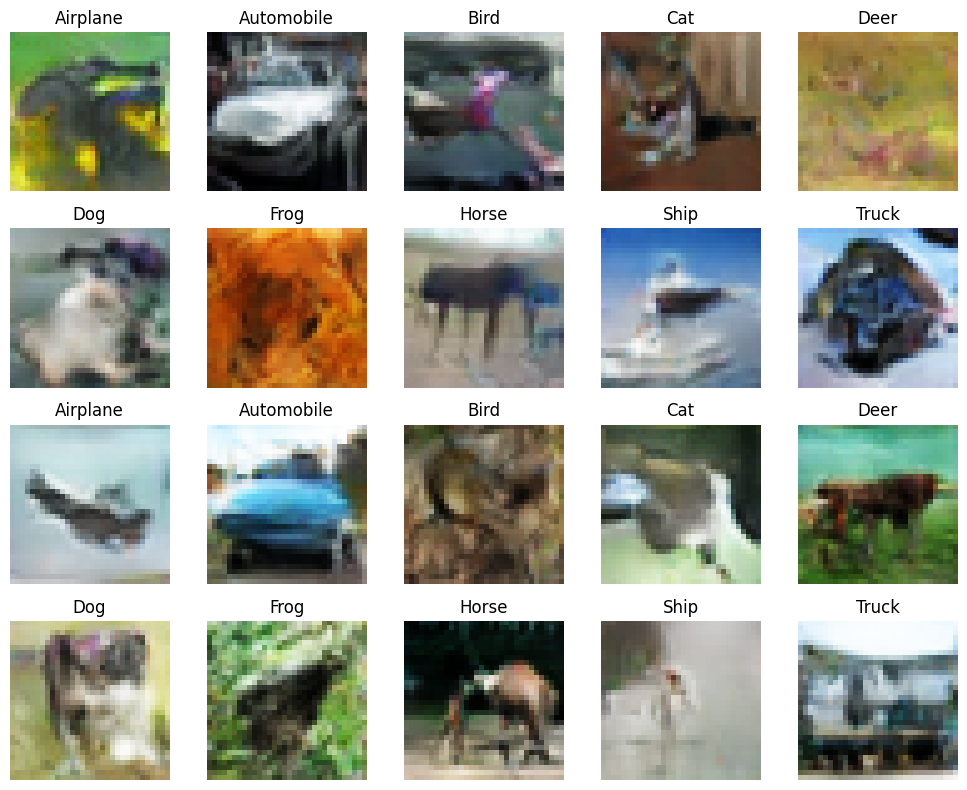

Generator Checkpoint - cGAN/generator-epoch-70.h5
Epoch 71/100
1875/1875 [==============================] - 284s 151ms/step - d_loss: 0.1130 - g_loss: 6.4622 - KL Divergence: 4.6571
Epoch 72/100
1875/1875 [==============================] - 289s 154ms/step - d_loss: 0.1094 - g_loss: 6.5799 - KL Divergence: 4.3823
Epoch 73/100
1875/1875 [==============================] - 291s 155ms/step - d_loss: 0.1111 - g_loss: 6.5457 - KL Divergence: 4.6741
Epoch 74/100
1875/1875 [==============================] - 290s 154ms/step - d_loss: 0.1066 - g_loss: 6.6227 - KL Divergence: 4.6237
Epoch 75/100
1/1 [==============================] - 0s 25ms/step


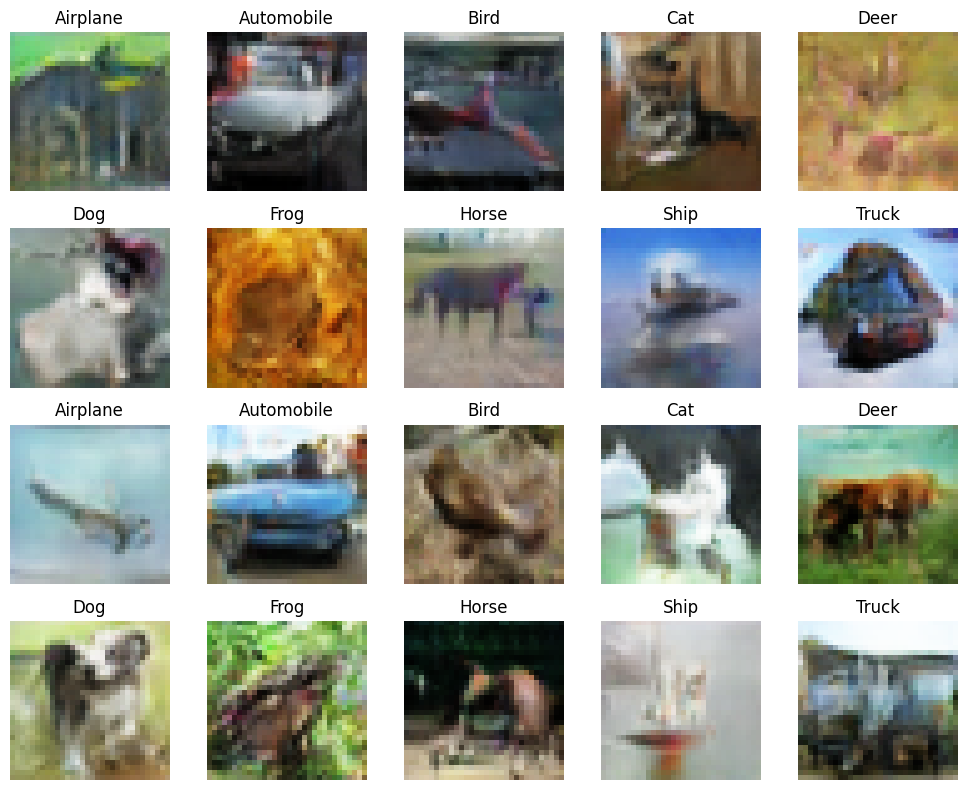

Generator Checkpoint - cGAN/generator-epoch-75.h5
Epoch 76/100
1875/1875 [==============================] - 286s 153ms/step - d_loss: 0.1075 - g_loss: 6.7137 - KL Divergence: 4.7521
Epoch 77/100
1875/1875 [==============================] - 276s 147ms/step - d_loss: 0.1065 - g_loss: 6.6124 - KL Divergence: 4.6804
Epoch 78/100
1875/1875 [==============================] - 286s 152ms/step - d_loss: 0.1110 - g_loss: 6.7395 - KL Divergence: 4.5162
Epoch 79/100
1875/1875 [==============================] - 286s 152ms/step - d_loss: 0.1071 - g_loss: 6.7056 - KL Divergence: 4.6781
Epoch 80/100
1/1 [==============================] - 0s 24ms/step


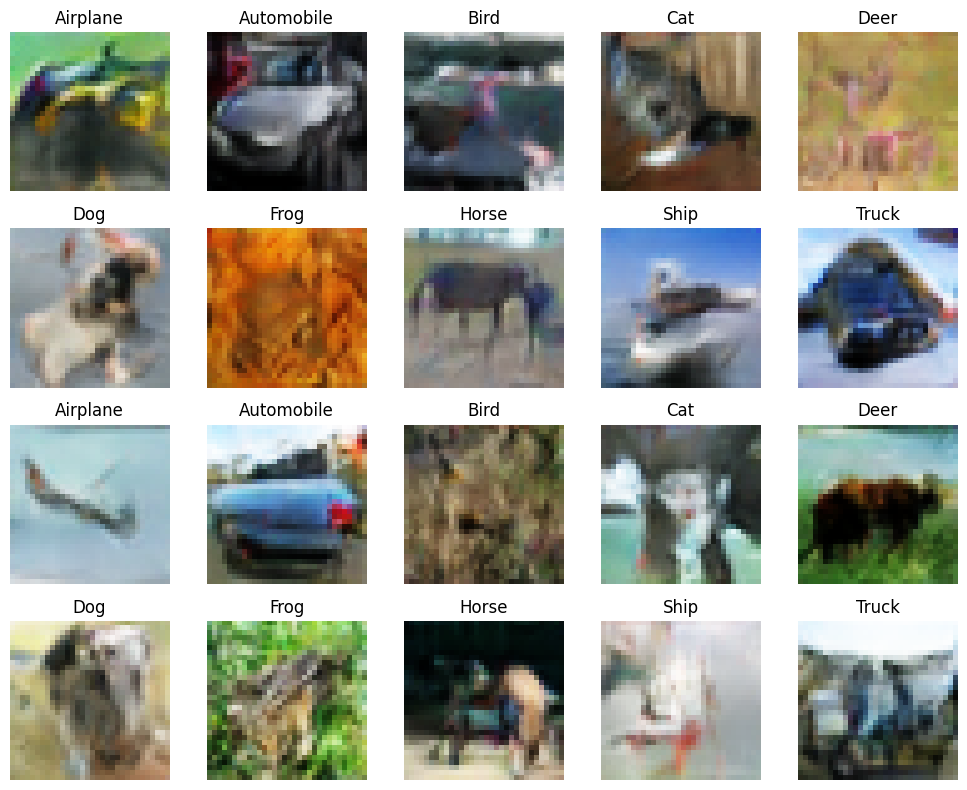

Generator Checkpoint - cGAN/generator-epoch-80.h5
Epoch 81/100
1875/1875 [==============================] - 280s 149ms/step - d_loss: 0.1036 - g_loss: 6.8385 - KL Divergence: 4.4479
Epoch 82/100
1875/1875 [==============================] - 301s 160ms/step - d_loss: 0.1041 - g_loss: 6.8705 - KL Divergence: 4.6812
Epoch 83/100
1875/1875 [==============================] - 280s 149ms/step - d_loss: 0.1030 - g_loss: 6.8977 - KL Divergence: 4.6251
Epoch 84/100
1875/1875 [==============================] - 273s 146ms/step - d_loss: 0.1039 - g_loss: 6.8800 - KL Divergence: 4.4934
Epoch 85/100
1/1 [==============================] - 0s 30ms/step


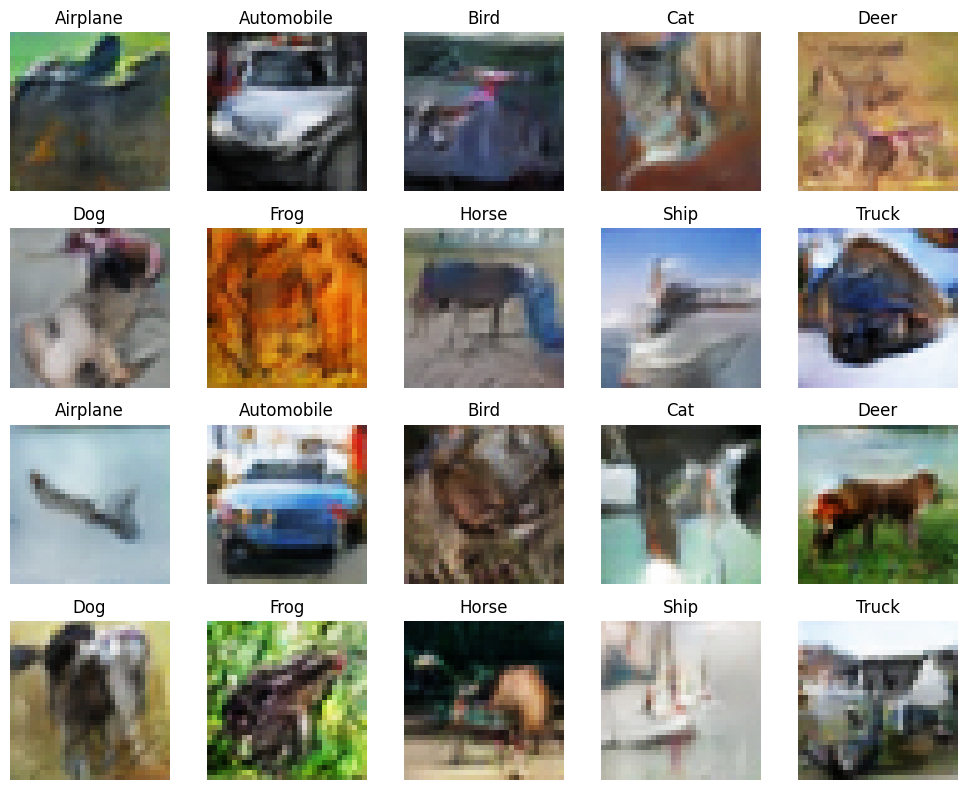

Generator Checkpoint - cGAN/generator-epoch-85.h5
Epoch 86/100
1875/1875 [==============================] - 291s 155ms/step - d_loss: 0.0959 - g_loss: 7.0273 - KL Divergence: 4.6262
Epoch 87/100
1875/1875 [==============================] - 290s 155ms/step - d_loss: 0.1001 - g_loss: 6.9324 - KL Divergence: 4.4268
Epoch 88/100
1875/1875 [==============================] - 273s 146ms/step - d_loss: 0.0980 - g_loss: 6.9376 - KL Divergence: 4.5927
Epoch 89/100
1875/1875 [==============================] - 275s 147ms/step - d_loss: 0.0976 - g_loss: 7.0986 - KL Divergence: 4.4295
Epoch 90/100
1/1 [==============================] - 0s 22ms/step


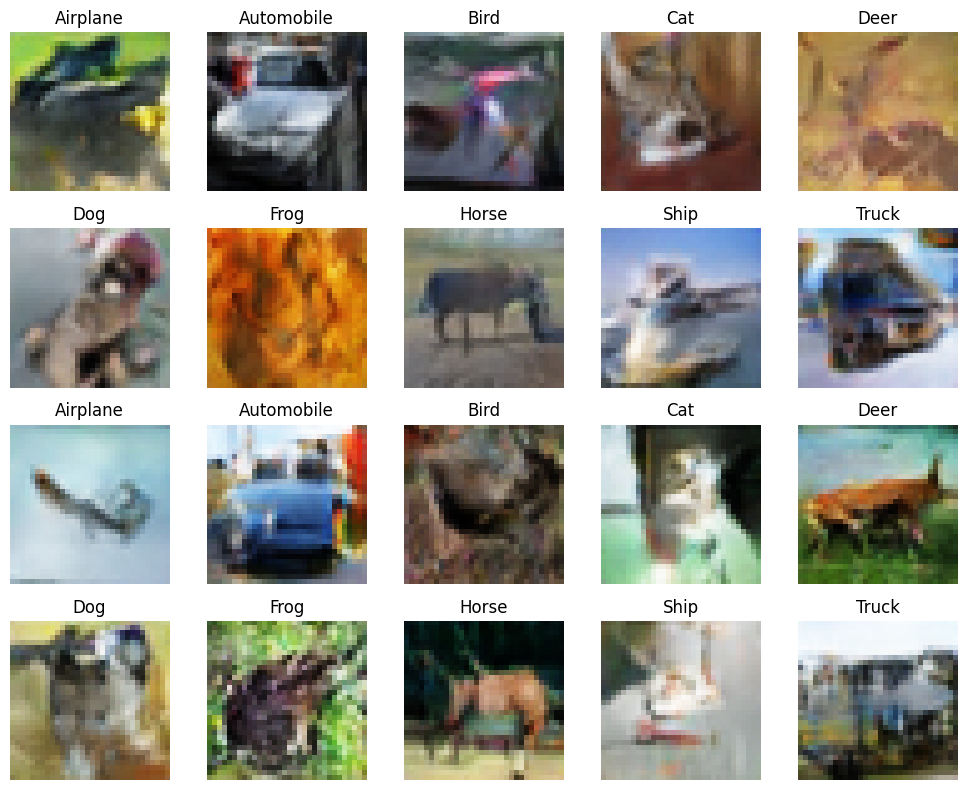

Generator Checkpoint - cGAN/generator-epoch-90.h5
Epoch 91/100
1875/1875 [==============================] - 289s 154ms/step - d_loss: 0.0992 - g_loss: 7.0449 - KL Divergence: 4.5005
Epoch 92/100
1875/1875 [==============================] - 290s 154ms/step - d_loss: 0.0943 - g_loss: 7.1077 - KL Divergence: 4.6322
Epoch 93/100
1875/1875 [==============================] - 282s 150ms/step - d_loss: 0.0926 - g_loss: 7.1482 - KL Divergence: 4.4731
Epoch 94/100
1875/1875 [==============================] - 281s 150ms/step - d_loss: 0.0920 - g_loss: 7.1063 - KL Divergence: 4.7347
Epoch 95/100
1/1 [==============================] - 0s 23ms/step


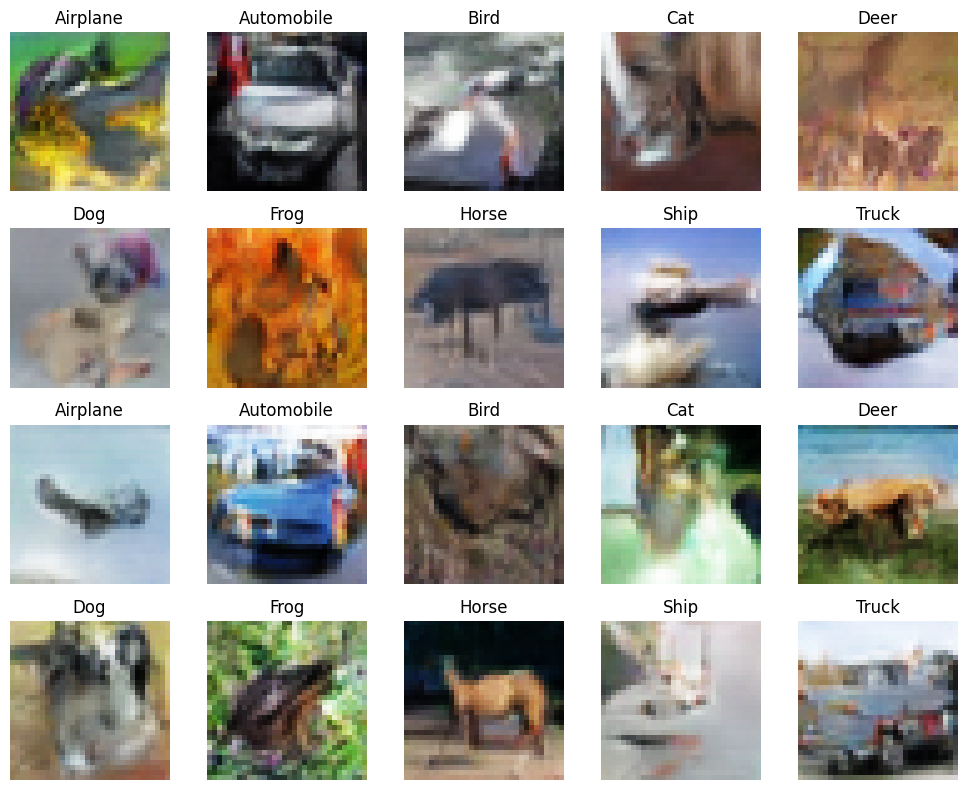

Generator Checkpoint - cGAN/generator-epoch-95.h5
Epoch 96/100
1875/1875 [==============================] - 305s 163ms/step - d_loss: 0.0930 - g_loss: 7.1853 - KL Divergence: 4.4747
Epoch 97/100
1875/1875 [==============================] - 274s 146ms/step - d_loss: 0.0948 - g_loss: 7.1752 - KL Divergence: 4.7670
Epoch 98/100
1875/1875 [==============================] - 273s 145ms/step - d_loss: 0.0911 - g_loss: 7.2463 - KL Divergence: 4.4961
Epoch 99/100
1875/1875 [==============================] - 275s 147ms/step - d_loss: 0.0907 - g_loss: 7.2388 - KL Divergence: 4.7671
Epoch 100/100
1/1 [==============================] - 0s 24ms/step


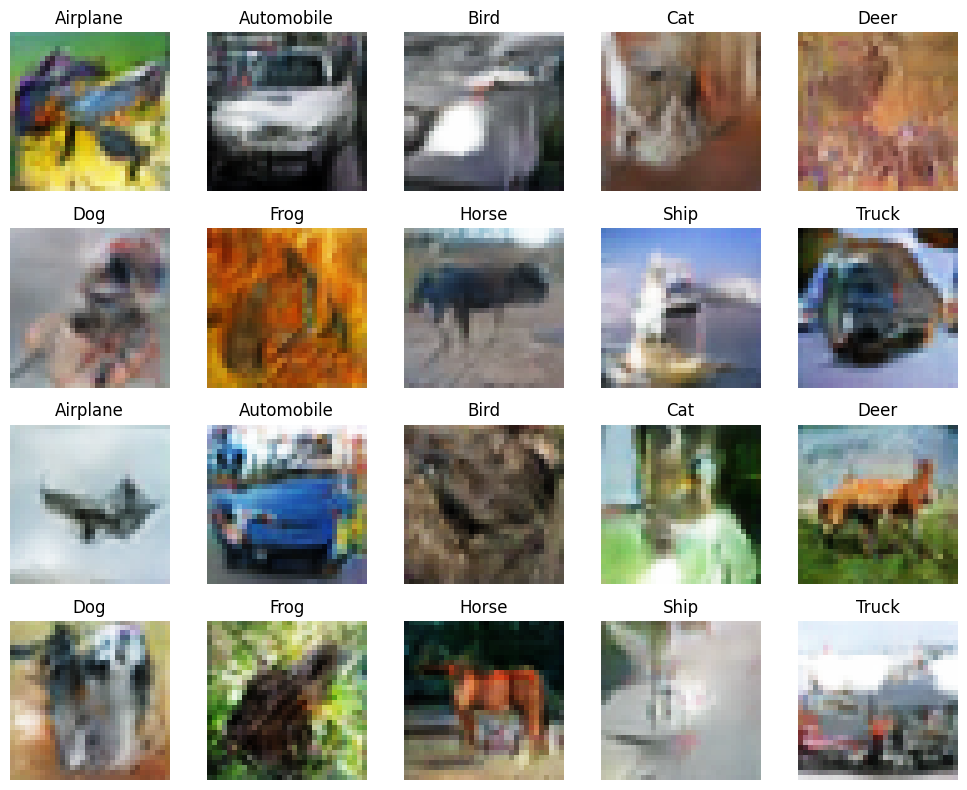

Generator Checkpoint - cGAN/generator-epoch-Full Train.h5


In [15]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(
    64, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

improve_cond_gan_hist = improve_cond_gan.fit(
    dataset, epochs=100, use_multiprocessing=True, workers=16, callbacks=callbacks)

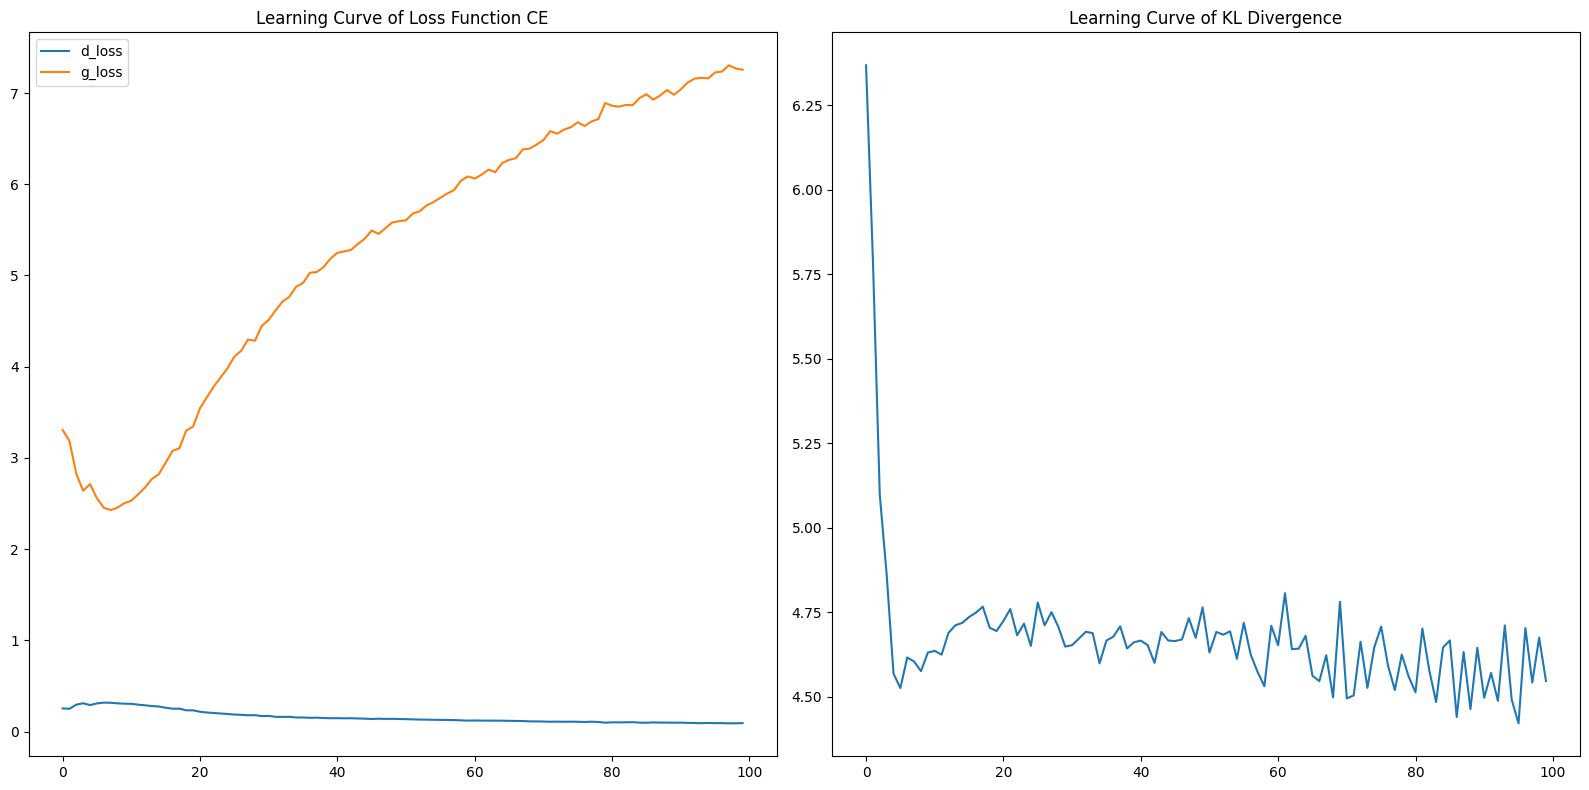

In [16]:
# story history object into dataframe
improve_cond_gan_hist_df = pd.DataFrame(improve_cond_gan_hist.history)

# using pandas dataframe to plot out learning curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), tight_layout=True)
improve_cond_gan_hist_df.loc[:, ["d_loss", 'g_loss']].plot(
    ax=ax1, title=r'Learning Curve of Loss Function CE')
improve_cond_gan_hist_df.loc[:, "KL Divergence"].plot(
    ax=ax2, title="Learning Curve of KL Divergence")
plt.show()

In [17]:
# Loading Weights for best Generator
best_epoch = 90
saved_weights = f'cGAN\generator-epoch-{best_epoch}.h5'
improve_cond_gan.generator.load_weights(saved_weights)

313/313 [==============================] - 4s 13ms/step
Latent Vector Dim: (10000, 128)	Generated Images Dim: (10000, 32, 32, 3)


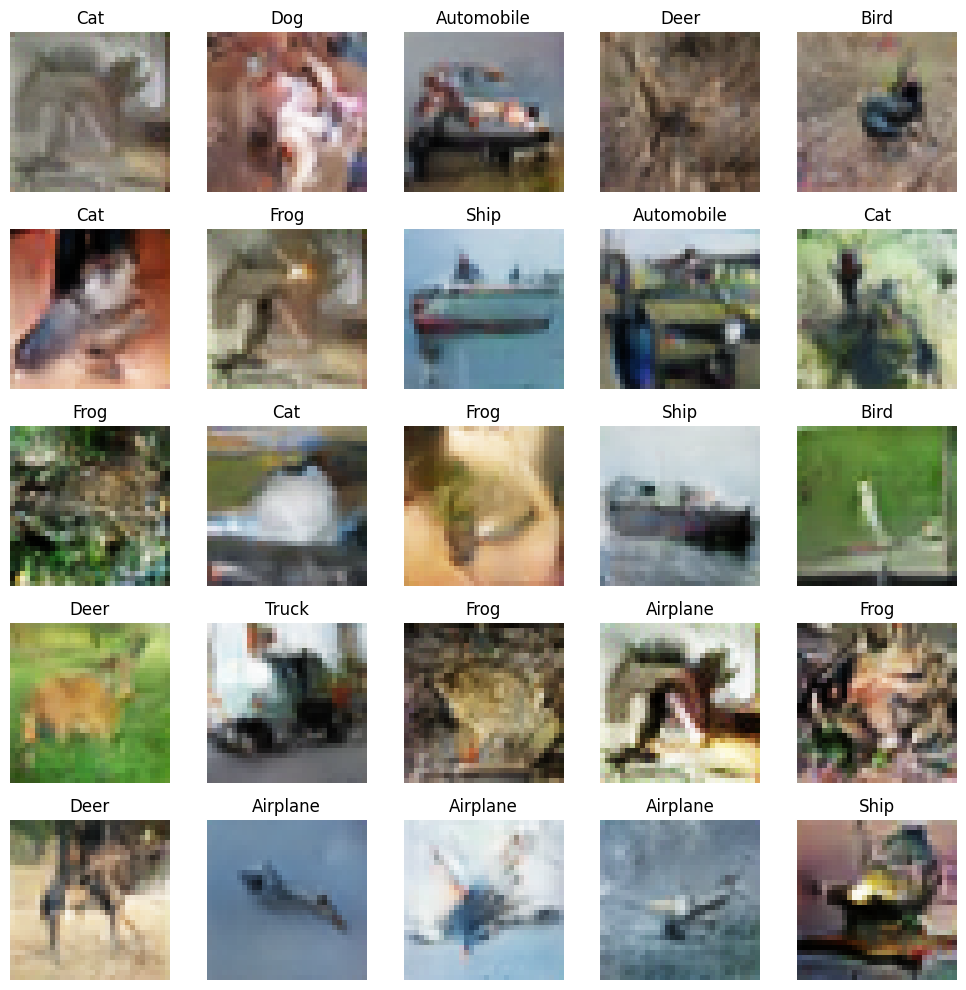

In [19]:
n = 10000

# generating labels
labels = np.random.randint(low=0, high=10, size=n)
one_hot_labels = to_categorical(labels)

# Generating 1000 Synthetic Images
random_noise = tf.random.normal(shape=(n, 128))

synthetic_images = improve_cond_gan.generator.predict(
    [random_noise, one_hot_labels])
print("Latent Vector Dim: {}\tGenerated Images Dim: {}".format(
    random_noise.shape, synthetic_images.shape))

# Scaling back to [0, 1]
synthetic_images -= -1
synthetic_images /= (1 - (-1))

# Display 25 randomly sampled images
fig = plt.figure(figsize=(10, 10), tight_layout=True)
for i in range(25):
    rand_idx = np.random.randint(0, len(synthetic_images))
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(synthetic_images[rand_idx])
    ax.set_title(class_labels[labels[rand_idx]])
    ax.axis('off')
plt.show()

In [21]:
# inception score functions
# inception score

from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()
	# enumerate splits of images/predictions
	scores = list()
	n_part = floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# convert from uint8 to float32
		# subset = subset.astype('float32')
		# scale images to the required size
		subset = scale_images(subset, (299,299,3))
		# pre-process images, scale to [-1,1]
# 		subset = preprocess_input(subset)
		# predict p(y|x)
		p_yx = model.predict(subset)
		# calculate p(y)
		p_y = expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = mean(sum_kl_d)
		# undo the log
		is_score = exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg, is_std = mean(scores), std(scores)
	return is_avg, is_std

In [22]:
# find inception score of 10,000 generated synthetic images
is_avg, is_std = calculate_inception_score(synthetic_images)
print('score', is_avg, is_std)

32/32 [==============================] - 25s 770ms/step
score 5.109746 0.17146139
